In [1]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Domain variabel
x_temp = np.arange(35, 41, 0.1)     # Suhu
x_pulse = np.arange(60, 141, 1)     # Nadi
x_priority = np.arange(0, 101, 1)   # Prioritas

In [4]:
# Fungsi keanggotaan Suhu [cite: 33, 34]
temp_normal = fuzz.trimf(x_temp, [35, 36.5, 38])
temp_high = fuzz.trimf(x_temp, [37, 38.5, 40])

# Fungsi keanggotaan Nadi [cite: 36, 37]
pulse_normal = fuzz.trimf(x_pulse, [60, 80, 100])
pulse_fast = fuzz.trimf(x_pulse, [90, 115, 140])

# Fungsi keanggotaan Output Prioritas (Monotonik Tsukamoto) [cite: 40, 41]
priority_low = fuzz.trimf(x_priority, [0, 0, 50])
priority_med = fuzz.trimf(x_priority, [25, 50, 75])
priority_high = fuzz.trimf(x_priority, [50, 100, 100])

In [16]:
# Input pasien [cite: 44, 45]
temp_in = 38.0
pulse_in = 110

# Fuzzifikasi menggunakan interp_membership [cite: 53, 54, 55, 56]
u_temp_normal = fuzz.interp_membership(x_temp, temp_normal, temp_in)
u_temp_high = fuzz.interp_membership(x_temp, temp_high, temp_in)
u_pulse_normal = fuzz.interp_membership(x_pulse, pulse_normal, pulse_in)
u_pulse_fast = fuzz.interp_membership(x_pulse, pulse_fast, pulse_in)

print(f"Derajat keanggotaan suhu: Normal={u_temp_normal:.2f}, Tinggi={u_temp_high:.2f}")
print(f"Derajat keanggotaan nadi: Normal={u_pulse_normal:.2f}, Cepat={u_pulse_fast:.2f}")

Derajat keanggotaan suhu: Normal=0.00, Tinggi=0.67
Derajat keanggotaan nadi: Normal=0.00, Cepat=0.80


In [20]:
# --- Pastikan bagian Fuzzifikasi ini sudah dijalankan ---
# temp_in = 38.0
# pulse_in = 110
# u_temp_normal = fuzz.interp_membership(x_temp, temp_normal, temp_in)
# ... dst

# 5 Rule evaluation
# Rule 1: Jika suhu normal dan nadi normal -> prioritas rendah
alpha1 = min(u_temp_normal, u_pulse_normal) # Menggunakan 'u' bukan 'μ' [cite: 63]

# Rule 2: Jika suhu tinggi atau nadi cepat -> prioritas tinggi
alpha2 = max(u_temp_high, u_pulse_fast) # [cite: 66]

# Fungsi monotonik: mencari nilai prioritas (z) dari alpha
# Prioritas rendah (menurun) [cite: 70, 74]
z1 = 50 * (1 - alpha1)

# Prioritas tinggi (meningkat) [cite: 71, 75]
z2 = 50 + (50 * alpha2)

# Defuzzifikasi (rata-rata terbobot) [cite: 76, 77]
# Ditambahkan pengecekan agar tidak error pembagian nol
if (alpha1 + alpha2) > 0:
    z = (alpha1 * z1 + alpha2 * z2) / (alpha1 + alpha2)
else:
    z = 0

print("\n=== Hasil inferensi Tsukamoto ===")
print(f"a1={alpha1:.2f}, z1={z1:.2f}") # [cite: 80, 82]
print(f"a2={alpha2:.2f}, z2={z2:.2f}") # [cite: 83, 85]
print(f"Output (z*) = {z:.2f}")         # [cite: 86]


=== Hasil inferensi Tsukamoto ===
a1=0.00, z1=50.00
a2=0.80, z2=90.00
Output (z*) = 90.00


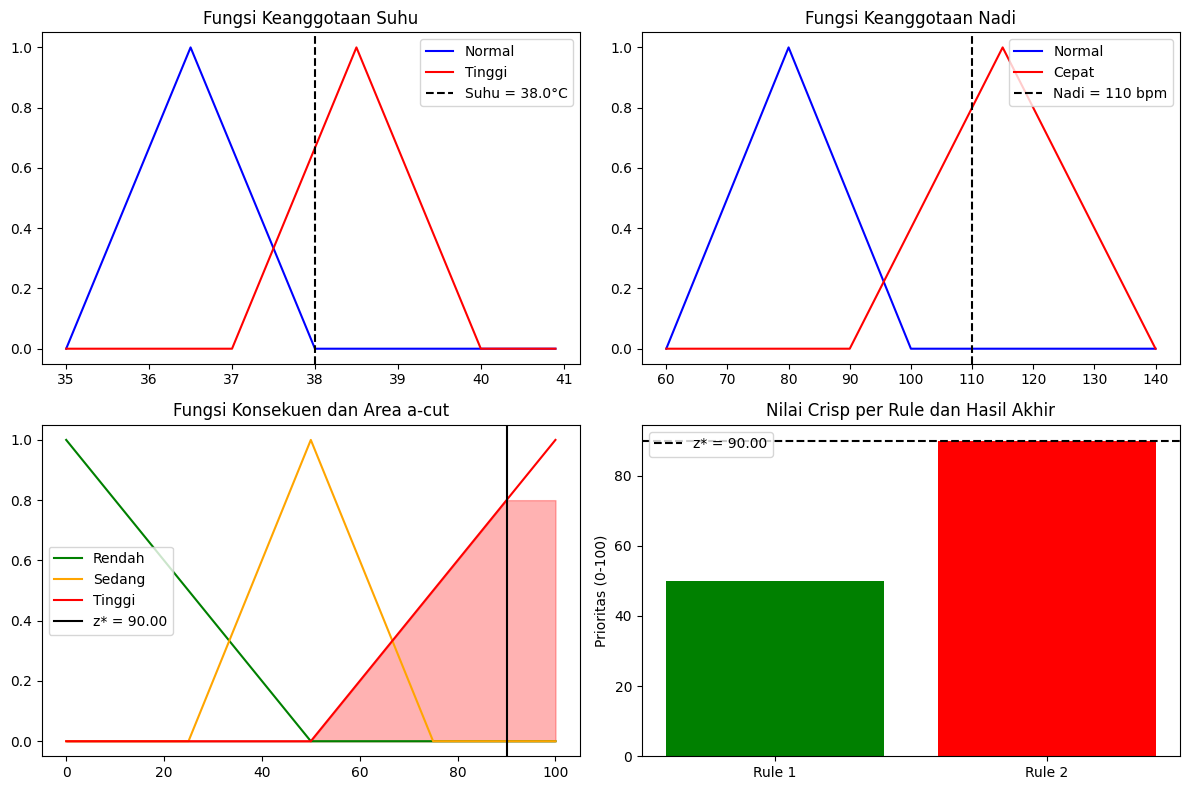

In [22]:
# --- PASTIKAN SEBELUMNYA SUDAH RUN IMPORT DAN HITUNGAN ---
import matplotlib.pyplot as plt
import numpy as np

# Membuat layout grid 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# 1. Plot Fungsi Keanggotaan Suhu (Kiri Atas)
axs[0,0].plot(x_temp, temp_normal, 'b', label='Normal')
axs[0,0].plot(x_temp, temp_high, 'r', label='Tinggi')
axs[0,0].axvline(temp_in, color='k', linestyle='--', label=f'Suhu = {temp_in}°C')
axs[0,0].set_title('Fungsi Keanggotaan Suhu')
axs[0,0].legend()

# 2. Plot Fungsi Keanggotaan Nadi (Kanan Atas)
axs[0,1].plot(x_pulse, pulse_normal, 'b', label='Normal')
axs[0,1].plot(x_pulse, pulse_fast, 'r', label='Cepat')
axs[0,1].axvline(pulse_in, color='k', linestyle='--', label=f'Nadi = {pulse_in} bpm')
axs[0,1].set_title('Fungsi Keanggotaan Nadi')
axs[0,1].legend()

# 3. Plot Output Prioritas & Area Alpha-cut (Kiri Bawah)
axs[1,0].plot(x_priority, priority_low, 'g', label='Rendah')
axs[1,0].plot(x_priority, priority_med, 'orange', label='Sedang')
axs[1,0].plot(x_priority, priority_high, 'r', label='Tinggi')

# Menampilkan area arsiran (alpha-cut) sesuai hasil rule
axs[1,0].fill_between(x_priority, 0, np.fmin(alpha1, priority_low), color='g', alpha=0.3)
axs[1,0].fill_between(x_priority, 0, np.fmin(alpha2, priority_high), color='r', alpha=0.3)

# Garis vertikal untuk hasil akhir defuzzifikasi
axs[1,0].axvline(z, color='k', linestyle='-', label=f'z* = {z:.2f}')
axs[1,0].set_title('Fungsi Konsekuen dan Area a-cut')
axs[1,0].legend()

# 4. Bar Chart Hasil Akhir per Rule (Kanan Bawah)
axs[1,1].bar(['Rule 1', 'Rule 2'], [z1, z2], color=['g', 'r'])
axs[1,1].axhline(z, color='k', linestyle='--', label=f'z* = {z:.2f}')
axs[1,1].set_ylabel('Prioritas (0-100)')
axs[1,1].set_title('Nilai Crisp per Rule dan Hasil Akhir')
axs[1,1].legend()

plt.tight_layout()
plt.show()